# Regresja liniowa na danych ubezpieczeniowych  

In [14]:
# !pip install pyspark
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

> 1. Wczytaj dane`'insurance.csv`
> 2. Za pomocą `StringIndexer` zamień kolumny `gender`, `smoker`, `region` na zmienne kategoryczne
> 3. Użyj `VectorAssembler` i stwórz kolumnę [`age`, `bmi`, `children`, `gender_cat`, `smoker_cat`, `region_cat`]
> 4. Zastosuj `StandardScaler`
> 5. Za pomocą `randomSplit` podziel dane na treningowe i testowe
> 6. Wytrenuj `LinearRegression` na danych treningowych
> 7. Wytrenowany algorytm użyj do otrzymania predykcji na danych testowych
> 8. Dowolną miarą sprawdź skuteczność algorytmu

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

df = spark.read.csv("./insurance.csv", header=True, inferSchema=True)
df = df.withColumnRenamed("expenses", "label")

df_train, df_eval = df.randomSplit([0.7, 0.3], 42)

df.show(5)
df.printSchema()

+---+------+----+--------+------+---------+--------+
|age|gender| bmi|children|smoker|   region|   label|
+---+------+----+--------+------+---------+--------+
| 19|female|27.9|       0|   yes|southwest|16884.92|
| 18|  male|33.8|       1|    no|southeast| 1725.55|
| 28|  male|33.0|       3|    no|southeast| 4449.46|
| 33|  male|22.7|       0|    no|northwest|21984.47|
| 32|  male|28.9|       0|    no|northwest| 3866.86|
+---+------+----+--------+------+---------+--------+
only showing top 5 rows

root
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- label: double (nullable = true)



In [37]:
idx = StringIndexer(inputCols=["gender", "smoker", "region"],
                    outputCols=["gender_cat", "smoker_cat", "region_cat"])

va = VectorAssembler(inputCols= ["age", "bmi", "children", "gender_cat", "smoker_cat", "region_cat"],
                     outputCol="featuresFull")

sc = StandardScaler(inputCol="featuresFull", outputCol="features")

reg = LinearRegression(maxIter=5, regParam=10)
er2 = RegressionEvaluator(metricName="r2")

pip = Pipeline(stages=[idx, va, sc, reg])

pip_model = pip.fit(df_train)

pred = pip_model.transform(df_eval)
pred.select("label", "features", "prediction").show()

print(f'R^2: {er2.evaluate(pred)}')

+--------+--------------------+------------------+
|   label|            features|        prediction|
+--------+--------------------+------------------+
|  2201.1|[1.29065589749760...|  1138.14989662699|
|18223.45|[1.29065589749760...|26413.987235709807|
| 7323.73|[1.29065589749760...|2412.9604423219334|
| 2203.47|[1.29065589749760...|  2715.21614252367|
| 1622.19|[1.29065589749760...|3092.7575080650186|
| 4561.19|[1.29065589749760...| 5139.895536941456|
| 2205.98|[1.29065589749760...|3319.7275429271376|
| 2211.13|[1.29065589749760...| 4562.334310423163|
|36149.48|[1.29065589749760...|28146.982167266848|
| 1631.67|[1.29065589749760...| 5376.467242922574|
| 1631.82|[1.29065589749760...| 5410.051209611653|
| 1633.96|[1.29065589749760...| 5913.810709947878|
| 2217.47|[1.29065589749760...| 6107.196778120919|
|  2217.6|[1.29065589749760...|6140.7807448099975|
|38792.69|[1.29065589749760...|29926.932401788174|
|12829.46|[1.29065589749760...|22269.607347105703|
| 1702.46|[1.29065589749760...|

(-1936.9065, 65665.71650000001, -3098.69339700117, 42048.882665404744)

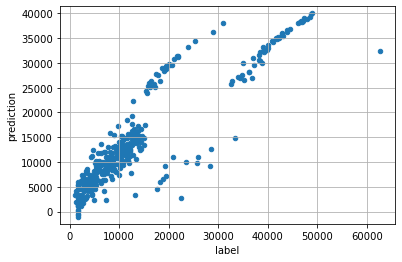

In [57]:
res = pred.select("label", "prediction").toPandas()
res.plot("label", "prediction", kind="scatter", grid=True).axis('equal')